In [53]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.handlers import FastaiLRFinder

In [54]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [31]:
root = os.path.join('.', 'data/speech_commands')

In [32]:
paths = []
labels = []
labels_categorical = []

# Subfolder iteration
for ind, subdir in enumerate(os.listdir(root)):
    subdir_path = os.path.join(root, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for file in os.listdir(subdir_path)[:300]:
        filepath = os.path.join(subdir_path, file)
        if filepath.endswith('.wav'):
            paths.append(filepath)
            labels.append(ind)
            labels_categorical.append(subdir)

logfbank_feats = []

#  logFBank feature extraction with progress bar
for signal_path in tqdm(paths, desc="Audio processing"):
    fs, sig = wav.read(signal_path)
    fbank_feat = logfbank(sig, samplerate=fs)
    logfbank_feats.append(fbank_feat)

# Padding up to one length
lengths = [i.shape[0] for i in logfbank_feats]
max_len = np.max(lengths)
feat_dim = logfbank_feats[0].shape[1]

padded_feats = np.zeros((len(logfbank_feats), max_len, feat_dim))

for i, feats in enumerate(logfbank_feats):
    pad_width = max_len - feats.shape[0]
    pad_before = pad_width // 2
    pad_after = pad_width - pad_before
    padded_feats[i, :, :] = np.pad(feats, ((pad_before, pad_after), (0, 0)), mode='constant')

# Save temporary
np.save('data/processed/logfbank_feats.npy', padded_feats)
np.save('data/processed/labels.npy', np.array(labels))
np.save('data/processed/labels_categorical.npy', np.array(labels_categorical))

Audio processing:  99%|█████████▉| 10429/10506 [00:14<00:00, 747.65it/s]C:\Users\Ignacy\AppData\Local\Temp\ipykernel_10960\2736930703.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, sig = wav.read(signal_path)
Audio processing: 100%|██████████| 10506/10506 [00:14<00:00, 715.61it/s]


In [33]:
feats = np.load('data/processed/logfbank_feats.npy')
labels = np.load('data/processed/labels.npy')

#  (num_samples, time, filters) → (num_samples, time * filters)
feats = feats.reshape(feats.shape[0], -1)
feats = feats.astype(np.float32)

# Splitting into training (80%) and provisional (20%) sets
X_train, X_val_test, y_train, y_val_test = train_test_split(
    feats,
    labels,
    random_state=42,
    stratify=labels,
    train_size=0.8
)

# Splitting the provisional set into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    random_state=42,
    stratify=y_val_test,
    train_size=0.5
)

print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_val: {X_val.shape}")
print(f"Size of X_test: {X_test.shape}")

Size of X_train: (8404, 247442)
Size of X_val: (1051, 247442)
Size of X_test: (1051, 247442)


In [34]:
trainset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
testset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [35]:
train_loader = DataLoader(trainset, batch_size = 256)
val_loader = DataLoader(valset, batch_size = 256)
test_loader = DataLoader(testset, batch_size = 256)

In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(247442, 2504) 
        self.fc2 = nn.Linear(2504, 256)
        self.fc3 = nn.Linear(256, 120)
        self.fc4 = nn.Linear(120, 36)

        # Dropout (rejects some neurons randomly during training)
        self.dropout1 = nn.Dropout(p=0.5)   # 50% chance of "switching off" the neuron
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.2)
        

    def forward(self, x):
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.dropout3(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.NLLLoss()
model = Net()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr = 3e-4, momentum = 0.9)

In [79]:
init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

In [80]:
trainer = create_supervised_trainer(
    model,
    optimizer,
    criterion,
    device=device
)

c:\Users\Ignacy\Desktop\programowanie\Studia\sem6\AI_1\.venv\Lib\site-packages\ignite\handlers\lr_finder.py:293: UserWarning: skip_start is larger than the suggested LR found and it will not be visible on the plot. Please, make the value smaller.
  warnings.warn(


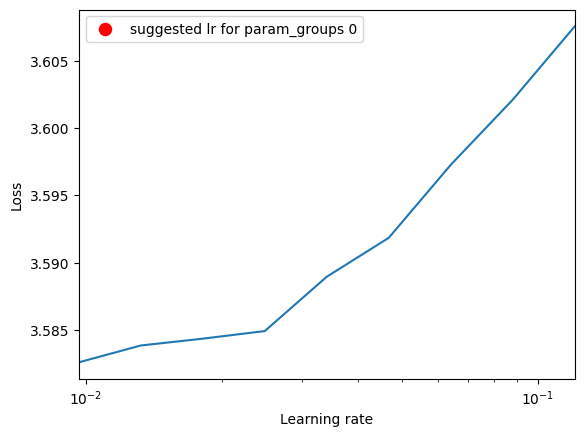

Suggested LR: 0.0037460770701952194


In [81]:
to_save = {'model': model, 'optimizer': optimizer}

lr_finder = FastaiLRFinder()

with lr_finder.attach(trainer, to_save, diverge_th=1.1) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

results = lr_finder.get_results()
lr_finder.plot()

print("Suggested LR:", lr_finder.lr_suggestion())

In [82]:
trainer = create_supervised_trainer(
    model, optimizer, criterion, device=device
)

evaluator = create_supervised_evaluator(
    model,
    metrics={
        "acc": Accuracy(),
        "loss": Loss(nn.NLLLoss())
    },
    device=device
)

ProgressBar(persist=True).attach(
    trainer,
    output_transform=lambda x: {"batch loss": x}
)

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {} | Avg accuracy: {:.2f} | Avg loss: {:.2f}".format(
        trainer.state.epoch, metrics['acc'], metrics['loss']
    ))

lr_finder.apply_suggested_lr(optimizer)
print('Training with suggested lr:', optimizer.param_groups[0]['lr'])

trainer.run(train_loader, max_epochs=250)

evaluator.run(test_loader)
print("Test set results:")
print(evaluator.state.metrics)

Training with suggested lr: 0.0037460770701952194


Epoch [1/250]: [33/33] 100%|██████████, batch loss=3.59 [01:21<00:00]


Validation Results - Epoch: 1 | Avg accuracy: 0.04 | Avg loss: 3.55


Epoch [2/250]: [33/33] 100%|██████████, batch loss=3.54 [01:21<00:00]


Validation Results - Epoch: 2 | Avg accuracy: 0.05 | Avg loss: 3.53


Epoch [3/250]: [33/33] 100%|██████████, batch loss=3.43 [01:21<00:00]


Validation Results - Epoch: 3 | Avg accuracy: 0.06 | Avg loss: 3.45


Epoch [4/250]: [33/33] 100%|██████████, batch loss=3.37 [01:21<00:00]


Validation Results - Epoch: 4 | Avg accuracy: 0.07 | Avg loss: 3.35


Epoch [5/250]: [33/33] 100%|██████████, batch loss=3.29 [01:20<00:00]


Validation Results - Epoch: 5 | Avg accuracy: 0.08 | Avg loss: 3.31


Epoch [6/250]: [33/33] 100%|██████████, batch loss=3.26 [01:21<00:00]


Validation Results - Epoch: 6 | Avg accuracy: 0.07 | Avg loss: 3.28


Epoch [7/250]: [33/33] 100%|██████████, batch loss=3.21 [01:21<00:00]


Validation Results - Epoch: 7 | Avg accuracy: 0.08 | Avg loss: 3.26


Epoch [8/250]: [33/33] 100%|██████████, batch loss=3.24 [01:22<00:00]


Validation Results - Epoch: 8 | Avg accuracy: 0.11 | Avg loss: 3.20


Epoch [9/250]: [33/33] 100%|██████████, batch loss=3.16 [01:22<00:00]


Validation Results - Epoch: 9 | Avg accuracy: 0.10 | Avg loss: 3.18


Epoch [10/250]: [33/33] 100%|██████████, batch loss=3.16 [01:21<00:00]


Validation Results - Epoch: 10 | Avg accuracy: 0.12 | Avg loss: 3.10


Epoch [11/250]: [33/33] 100%|██████████, batch loss=3.09 [01:21<00:00]


Validation Results - Epoch: 11 | Avg accuracy: 0.15 | Avg loss: 2.99


Epoch [12/250]: [33/33] 100%|██████████, batch loss=2.95 [01:21<00:00]


Validation Results - Epoch: 12 | Avg accuracy: 0.19 | Avg loss: 2.84


Epoch [13/250]: [33/33] 100%|██████████, batch loss=2.89 [01:22<00:00]


Validation Results - Epoch: 13 | Avg accuracy: 0.22 | Avg loss: 2.74


Epoch [14/250]: [33/33] 100%|██████████, batch loss=2.83 [01:22<00:00]


Validation Results - Epoch: 14 | Avg accuracy: 0.22 | Avg loss: 2.69


Epoch [15/250]: [33/33] 100%|██████████, batch loss=2.74 [01:21<00:00]


Validation Results - Epoch: 15 | Avg accuracy: 0.22 | Avg loss: 2.62


Epoch [16/250]: [33/33] 100%|██████████, batch loss=2.74 [01:22<00:00]


Validation Results - Epoch: 16 | Avg accuracy: 0.23 | Avg loss: 2.60


Epoch [17/250]: [33/33] 100%|██████████, batch loss=2.72 [01:22<00:00]


Validation Results - Epoch: 17 | Avg accuracy: 0.26 | Avg loss: 2.51


Epoch [18/250]: [33/33] 100%|██████████, batch loss=2.61 [01:22<00:00]


Validation Results - Epoch: 18 | Avg accuracy: 0.26 | Avg loss: 2.50


Epoch [19/250]: [33/33] 100%|██████████, batch loss=2.77 [01:22<00:00]


Validation Results - Epoch: 19 | Avg accuracy: 0.24 | Avg loss: 2.56


Epoch [20/250]: [33/33] 100%|██████████, batch loss=2.57 [01:22<00:00]


Validation Results - Epoch: 20 | Avg accuracy: 0.30 | Avg loss: 2.44


Epoch [21/250]: [33/33] 100%|██████████, batch loss=2.67 [01:22<00:00]


Validation Results - Epoch: 21 | Avg accuracy: 0.28 | Avg loss: 2.44


Epoch [22/250]: [33/33] 100%|██████████, batch loss=2.47 [01:21<00:00]


Validation Results - Epoch: 22 | Avg accuracy: 0.29 | Avg loss: 2.41


Epoch [23/250]: [33/33] 100%|██████████, batch loss=2.6 [01:21<00:00] 


Validation Results - Epoch: 23 | Avg accuracy: 0.34 | Avg loss: 2.33


Epoch [24/250]: [33/33] 100%|██████████, batch loss=2.52 [01:21<00:00]


Validation Results - Epoch: 24 | Avg accuracy: 0.31 | Avg loss: 2.37


Epoch [25/250]: [33/33] 100%|██████████, batch loss=2.48 [01:22<00:00]


Validation Results - Epoch: 25 | Avg accuracy: 0.36 | Avg loss: 2.26


Epoch [26/250]: [33/33] 100%|██████████, batch loss=2.44 [01:21<00:00]


Validation Results - Epoch: 26 | Avg accuracy: 0.35 | Avg loss: 2.25


Epoch [27/250]: [33/33] 100%|██████████, batch loss=2.41 [01:21<00:00]


Validation Results - Epoch: 27 | Avg accuracy: 0.32 | Avg loss: 2.35


Epoch [28/250]: [33/33] 100%|██████████, batch loss=2.45 [01:21<00:00]


Validation Results - Epoch: 28 | Avg accuracy: 0.35 | Avg loss: 2.23


Epoch [29/250]: [33/33] 100%|██████████, batch loss=2.48 [01:21<00:00]


Validation Results - Epoch: 29 | Avg accuracy: 0.36 | Avg loss: 2.25


Epoch [30/250]: [33/33] 100%|██████████, batch loss=2.35 [01:20<00:00]


Validation Results - Epoch: 30 | Avg accuracy: 0.35 | Avg loss: 2.23


Epoch [31/250]: [33/33] 100%|██████████, batch loss=2.38 [01:21<00:00]


Validation Results - Epoch: 31 | Avg accuracy: 0.35 | Avg loss: 2.25


Epoch [32/250]: [33/33] 100%|██████████, batch loss=2.41 [01:21<00:00]


Validation Results - Epoch: 32 | Avg accuracy: 0.38 | Avg loss: 2.14


Epoch [33/250]: [33/33] 100%|██████████, batch loss=2.38 [01:21<00:00]


Validation Results - Epoch: 33 | Avg accuracy: 0.37 | Avg loss: 2.16


Epoch [34/250]: [33/33] 100%|██████████, batch loss=2.38 [01:21<00:00]


Validation Results - Epoch: 34 | Avg accuracy: 0.39 | Avg loss: 2.13


Epoch [35/250]: [33/33] 100%|██████████, batch loss=2.34 [01:21<00:00]


Validation Results - Epoch: 35 | Avg accuracy: 0.39 | Avg loss: 2.17


Epoch [36/250]: [33/33] 100%|██████████, batch loss=2.46 [01:20<00:00]


Validation Results - Epoch: 36 | Avg accuracy: 0.40 | Avg loss: 2.11


Epoch [37/250]: [33/33] 100%|██████████, batch loss=2.32 [01:20<00:00]


Validation Results - Epoch: 37 | Avg accuracy: 0.41 | Avg loss: 2.12


Epoch [38/250]: [33/33] 100%|██████████, batch loss=2.25 [01:21<00:00]


Validation Results - Epoch: 38 | Avg accuracy: 0.41 | Avg loss: 2.06


Epoch [39/250]: [33/33] 100%|██████████, batch loss=2.34 [01:21<00:00]


Validation Results - Epoch: 39 | Avg accuracy: 0.39 | Avg loss: 2.09


Epoch [40/250]: [33/33] 100%|██████████, batch loss=2.31 [01:21<00:00]


Validation Results - Epoch: 40 | Avg accuracy: 0.42 | Avg loss: 2.04


Epoch [41/250]: [33/33] 100%|██████████, batch loss=2.2 [01:21<00:00] 


Validation Results - Epoch: 41 | Avg accuracy: 0.43 | Avg loss: 2.03


Epoch [42/250]: [33/33] 100%|██████████, batch loss=2.33 [01:21<00:00]


Validation Results - Epoch: 42 | Avg accuracy: 0.42 | Avg loss: 2.06


Epoch [43/250]: [33/33] 100%|██████████, batch loss=2.44 [01:20<00:00]


Validation Results - Epoch: 43 | Avg accuracy: 0.42 | Avg loss: 2.06


Epoch [44/250]: [33/33] 100%|██████████, batch loss=2.28 [01:21<00:00]


Validation Results - Epoch: 44 | Avg accuracy: 0.45 | Avg loss: 2.01


Epoch [45/250]: [33/33] 100%|██████████, batch loss=2.4 [01:21<00:00] 


Validation Results - Epoch: 45 | Avg accuracy: 0.43 | Avg loss: 2.02


Epoch [46/250]: [33/33] 100%|██████████, batch loss=2.23 [01:21<00:00]


Validation Results - Epoch: 46 | Avg accuracy: 0.44 | Avg loss: 1.99


Epoch [47/250]: [33/33] 100%|██████████, batch loss=2.3 [01:21<00:00] 


Validation Results - Epoch: 47 | Avg accuracy: 0.44 | Avg loss: 2.04


Epoch [48/250]: [33/33] 100%|██████████, batch loss=2.3 [01:21<00:00] 


Validation Results - Epoch: 48 | Avg accuracy: 0.43 | Avg loss: 2.07


Epoch [49/250]: [33/33] 100%|██████████, batch loss=2.2 [01:21<00:00] 


Validation Results - Epoch: 49 | Avg accuracy: 0.44 | Avg loss: 1.98


Epoch [50/250]: [33/33] 100%|██████████, batch loss=2.16 [01:21<00:00]


Validation Results - Epoch: 50 | Avg accuracy: 0.45 | Avg loss: 1.97


Epoch [51/250]: [33/33] 100%|██████████, batch loss=2.18 [01:21<00:00]


Validation Results - Epoch: 51 | Avg accuracy: 0.47 | Avg loss: 1.90


Epoch [52/250]: [33/33] 100%|██████████, batch loss=2.15 [01:21<00:00]


Validation Results - Epoch: 52 | Avg accuracy: 0.47 | Avg loss: 1.90


Epoch [53/250]: [33/33] 100%|██████████, batch loss=2.13 [01:21<00:00]


Validation Results - Epoch: 53 | Avg accuracy: 0.46 | Avg loss: 1.94


Epoch [54/250]: [33/33] 100%|██████████, batch loss=2.08 [01:21<00:00]


Validation Results - Epoch: 54 | Avg accuracy: 0.45 | Avg loss: 1.90


Epoch [55/250]: [33/33] 100%|██████████, batch loss=2.42 [01:21<00:00]


Validation Results - Epoch: 55 | Avg accuracy: 0.44 | Avg loss: 1.91


Epoch [56/250]: [33/33] 100%|██████████, batch loss=2.08 [01:21<00:00]


Validation Results - Epoch: 56 | Avg accuracy: 0.46 | Avg loss: 1.91


Epoch [57/250]: [33/33] 100%|██████████, batch loss=2.15 [01:21<00:00]


Validation Results - Epoch: 57 | Avg accuracy: 0.48 | Avg loss: 1.85


Epoch [58/250]: [33/33] 100%|██████████, batch loss=2.17 [01:20<00:00]


Validation Results - Epoch: 58 | Avg accuracy: 0.49 | Avg loss: 1.87


Epoch [59/250]: [33/33] 100%|██████████, batch loss=2.06 [01:20<00:00]


Validation Results - Epoch: 59 | Avg accuracy: 0.45 | Avg loss: 1.89


Epoch [60/250]: [33/33] 100%|██████████, batch loss=2.05 [01:20<00:00]


Validation Results - Epoch: 60 | Avg accuracy: 0.49 | Avg loss: 1.81


Epoch [61/250]: [33/33] 100%|██████████, batch loss=1.98 [01:20<00:00]


Validation Results - Epoch: 61 | Avg accuracy: 0.49 | Avg loss: 1.81


Epoch [62/250]: [33/33] 100%|██████████, batch loss=2.09 [01:20<00:00]


Validation Results - Epoch: 62 | Avg accuracy: 0.47 | Avg loss: 1.82


Epoch [63/250]: [33/33] 100%|██████████, batch loss=2.12 [01:20<00:00]


Validation Results - Epoch: 63 | Avg accuracy: 0.51 | Avg loss: 1.79


Epoch [64/250]: [33/33] 100%|██████████, batch loss=2.02 [01:20<00:00]


Validation Results - Epoch: 64 | Avg accuracy: 0.48 | Avg loss: 1.81


Epoch [65/250]: [33/33] 100%|██████████, batch loss=2.02 [01:20<00:00]


Validation Results - Epoch: 65 | Avg accuracy: 0.49 | Avg loss: 1.81


Epoch [66/250]: [33/33] 100%|██████████, batch loss=2.01 [01:20<00:00]


Validation Results - Epoch: 66 | Avg accuracy: 0.51 | Avg loss: 1.76


Epoch [67/250]: [33/33] 100%|██████████, batch loss=1.91 [01:20<00:00]


Validation Results - Epoch: 67 | Avg accuracy: 0.52 | Avg loss: 1.74


Epoch [68/250]: [33/33] 100%|██████████, batch loss=1.91 [01:21<00:00]


Validation Results - Epoch: 68 | Avg accuracy: 0.50 | Avg loss: 1.73


Epoch [69/250]: [33/33] 100%|██████████, batch loss=1.93 [01:20<00:00]


Validation Results - Epoch: 69 | Avg accuracy: 0.53 | Avg loss: 1.76


Epoch [70/250]: [33/33] 100%|██████████, batch loss=1.96 [01:20<00:00]


Validation Results - Epoch: 70 | Avg accuracy: 0.52 | Avg loss: 1.71


Epoch [71/250]: [33/33] 100%|██████████, batch loss=1.86 [01:20<00:00]


Validation Results - Epoch: 71 | Avg accuracy: 0.52 | Avg loss: 1.70


Epoch [72/250]: [33/33] 100%|██████████, batch loss=1.97 [01:20<00:00]


Validation Results - Epoch: 72 | Avg accuracy: 0.53 | Avg loss: 1.71


Epoch [73/250]: [33/33] 100%|██████████, batch loss=1.91 [01:20<00:00]


Validation Results - Epoch: 73 | Avg accuracy: 0.51 | Avg loss: 1.68


Epoch [74/250]: [33/33] 100%|██████████, batch loss=1.92 [01:20<00:00]


Validation Results - Epoch: 74 | Avg accuracy: 0.51 | Avg loss: 1.74


Epoch [75/250]: [33/33] 100%|██████████, batch loss=1.88 [01:20<00:00]


Validation Results - Epoch: 75 | Avg accuracy: 0.52 | Avg loss: 1.70


Epoch [76/250]: [33/33] 100%|██████████, batch loss=1.9 [01:20<00:00] 


Validation Results - Epoch: 76 | Avg accuracy: 0.54 | Avg loss: 1.67


Epoch [77/250]: [33/33] 100%|██████████, batch loss=1.9 [01:20<00:00] 


Validation Results - Epoch: 77 | Avg accuracy: 0.53 | Avg loss: 1.63


Epoch [78/250]: [33/33] 100%|██████████, batch loss=1.89 [01:21<00:00]


Validation Results - Epoch: 78 | Avg accuracy: 0.52 | Avg loss: 1.73


Epoch [79/250]: [33/33] 100%|██████████, batch loss=1.97 [01:20<00:00]


Validation Results - Epoch: 79 | Avg accuracy: 0.52 | Avg loss: 1.70


Epoch [80/250]: [33/33] 100%|██████████, batch loss=1.74 [01:21<00:00]


Validation Results - Epoch: 80 | Avg accuracy: 0.52 | Avg loss: 1.67


Epoch [81/250]: [33/33] 100%|██████████, batch loss=1.87 [01:21<00:00]


Validation Results - Epoch: 81 | Avg accuracy: 0.53 | Avg loss: 1.71


Epoch [82/250]: [33/33] 100%|██████████, batch loss=1.77 [01:20<00:00]


Validation Results - Epoch: 82 | Avg accuracy: 0.52 | Avg loss: 1.64


Epoch [83/250]: [33/33] 100%|██████████, batch loss=1.8 [01:20<00:00] 


Validation Results - Epoch: 83 | Avg accuracy: 0.53 | Avg loss: 1.64


Epoch [84/250]: [33/33] 100%|██████████, batch loss=1.7 [01:21<00:00] 


Validation Results - Epoch: 84 | Avg accuracy: 0.54 | Avg loss: 1.64


Epoch [85/250]: [33/33] 100%|██████████, batch loss=1.86 [01:20<00:00]


Validation Results - Epoch: 85 | Avg accuracy: 0.54 | Avg loss: 1.62


Epoch [86/250]: [33/33] 100%|██████████, batch loss=1.77 [01:20<00:00]


Validation Results - Epoch: 86 | Avg accuracy: 0.56 | Avg loss: 1.58


Epoch [87/250]: [33/33] 100%|██████████, batch loss=1.74 [01:20<00:00]


Validation Results - Epoch: 87 | Avg accuracy: 0.58 | Avg loss: 1.56


Epoch [88/250]: [33/33] 100%|██████████, batch loss=1.72 [01:20<00:00]


Validation Results - Epoch: 88 | Avg accuracy: 0.57 | Avg loss: 1.53


Epoch [89/250]: [33/33] 100%|██████████, batch loss=1.74 [01:21<00:00]


Validation Results - Epoch: 89 | Avg accuracy: 0.57 | Avg loss: 1.53


Epoch [90/250]: [33/33] 100%|██████████, batch loss=1.67 [01:20<00:00]


Validation Results - Epoch: 90 | Avg accuracy: 0.56 | Avg loss: 1.54


Epoch [91/250]: [33/33] 100%|██████████, batch loss=1.86 [01:20<00:00]


Validation Results - Epoch: 91 | Avg accuracy: 0.55 | Avg loss: 1.56


Epoch [92/250]: [33/33] 100%|██████████, batch loss=1.82 [01:21<00:00]


Validation Results - Epoch: 92 | Avg accuracy: 0.58 | Avg loss: 1.53


Epoch [93/250]: [33/33] 100%|██████████, batch loss=1.83 [01:20<00:00]


Validation Results - Epoch: 93 | Avg accuracy: 0.57 | Avg loss: 1.55


Epoch [94/250]: [33/33] 100%|██████████, batch loss=1.64 [01:20<00:00]


Validation Results - Epoch: 94 | Avg accuracy: 0.56 | Avg loss: 1.54


Epoch [95/250]: [33/33] 100%|██████████, batch loss=1.73 [01:21<00:00]


Validation Results - Epoch: 95 | Avg accuracy: 0.57 | Avg loss: 1.49


Epoch [96/250]: [33/33] 100%|██████████, batch loss=1.65 [01:20<00:00]


Validation Results - Epoch: 96 | Avg accuracy: 0.57 | Avg loss: 1.54


Epoch [97/250]: [33/33] 100%|██████████, batch loss=1.54 [01:21<00:00]


Validation Results - Epoch: 97 | Avg accuracy: 0.59 | Avg loss: 1.49


Epoch [98/250]: [33/33] 100%|██████████, batch loss=1.68 [01:20<00:00]


Validation Results - Epoch: 98 | Avg accuracy: 0.56 | Avg loss: 1.52


Epoch [99/250]: [33/33] 100%|██████████, batch loss=1.69 [01:20<00:00]


Validation Results - Epoch: 99 | Avg accuracy: 0.57 | Avg loss: 1.53


Epoch [100/250]: [33/33] 100%|██████████, batch loss=1.65 [01:21<00:00]


Validation Results - Epoch: 100 | Avg accuracy: 0.59 | Avg loss: 1.50


Epoch [101/250]: [33/33] 100%|██████████, batch loss=1.8 [01:20<00:00] 


Validation Results - Epoch: 101 | Avg accuracy: 0.57 | Avg loss: 1.49


Epoch [102/250]: [33/33] 100%|██████████, batch loss=1.62 [01:21<00:00]


Validation Results - Epoch: 102 | Avg accuracy: 0.59 | Avg loss: 1.47


Epoch [103/250]: [33/33] 100%|██████████, batch loss=1.56 [01:20<00:00]


Validation Results - Epoch: 103 | Avg accuracy: 0.58 | Avg loss: 1.50


Epoch [104/250]: [33/33] 100%|██████████, batch loss=1.52 [01:20<00:00]


Validation Results - Epoch: 104 | Avg accuracy: 0.59 | Avg loss: 1.47


Epoch [105/250]: [33/33] 100%|██████████, batch loss=1.65 [01:21<00:00]


Validation Results - Epoch: 105 | Avg accuracy: 0.58 | Avg loss: 1.47


Epoch [106/250]: [33/33] 100%|██████████, batch loss=1.58 [01:21<00:00]


Validation Results - Epoch: 106 | Avg accuracy: 0.57 | Avg loss: 1.48


Epoch [107/250]: [33/33] 100%|██████████, batch loss=1.5 [01:20<00:00] 


Validation Results - Epoch: 107 | Avg accuracy: 0.58 | Avg loss: 1.44


Epoch [108/250]: [33/33] 100%|██████████, batch loss=1.59 [01:21<00:00]


Validation Results - Epoch: 108 | Avg accuracy: 0.59 | Avg loss: 1.44


Epoch [109/250]: [33/33] 100%|██████████, batch loss=1.54 [01:20<00:00]


Validation Results - Epoch: 109 | Avg accuracy: 0.61 | Avg loss: 1.42


Epoch [110/250]: [33/33] 100%|██████████, batch loss=1.56 [01:20<00:00]


Validation Results - Epoch: 110 | Avg accuracy: 0.59 | Avg loss: 1.43


Epoch [111/250]: [33/33] 100%|██████████, batch loss=1.66 [01:20<00:00]


Validation Results - Epoch: 111 | Avg accuracy: 0.61 | Avg loss: 1.40


Epoch [112/250]: [33/33] 100%|██████████, batch loss=1.62 [01:20<00:00]


Validation Results - Epoch: 112 | Avg accuracy: 0.59 | Avg loss: 1.41


Epoch [113/250]: [33/33] 100%|██████████, batch loss=1.47 [01:21<00:00]


Validation Results - Epoch: 113 | Avg accuracy: 0.62 | Avg loss: 1.36


Epoch [114/250]: [33/33] 100%|██████████, batch loss=1.72 [01:20<00:00]


Validation Results - Epoch: 114 | Avg accuracy: 0.61 | Avg loss: 1.40


Epoch [115/250]: [33/33] 100%|██████████, batch loss=1.46 [01:20<00:00]


Validation Results - Epoch: 115 | Avg accuracy: 0.61 | Avg loss: 1.40


Epoch [116/250]: [33/33] 100%|██████████, batch loss=1.62 [01:21<00:00]


Validation Results - Epoch: 116 | Avg accuracy: 0.60 | Avg loss: 1.41


Epoch [117/250]: [33/33] 100%|██████████, batch loss=1.47 [01:20<00:00]


Validation Results - Epoch: 117 | Avg accuracy: 0.60 | Avg loss: 1.40


Epoch [118/250]: [33/33] 100%|██████████, batch loss=1.48 [01:20<00:00]


Validation Results - Epoch: 118 | Avg accuracy: 0.60 | Avg loss: 1.39


Epoch [119/250]: [33/33] 100%|██████████, batch loss=1.47 [01:21<00:00]


Validation Results - Epoch: 119 | Avg accuracy: 0.63 | Avg loss: 1.38


Epoch [120/250]: [33/33] 100%|██████████, batch loss=1.53 [01:20<00:00]


Validation Results - Epoch: 120 | Avg accuracy: 0.62 | Avg loss: 1.39


Epoch [121/250]: [33/33] 100%|██████████, batch loss=1.53 [01:21<00:00]


Validation Results - Epoch: 121 | Avg accuracy: 0.59 | Avg loss: 1.41


Epoch [122/250]: [33/33] 100%|██████████, batch loss=1.57 [01:21<00:00]


Validation Results - Epoch: 122 | Avg accuracy: 0.61 | Avg loss: 1.42


Epoch [123/250]: [33/33] 100%|██████████, batch loss=1.48 [01:21<00:00]


Validation Results - Epoch: 123 | Avg accuracy: 0.62 | Avg loss: 1.37


Epoch [124/250]: [33/33] 100%|██████████, batch loss=1.51 [01:20<00:00]


Validation Results - Epoch: 124 | Avg accuracy: 0.63 | Avg loss: 1.32


Epoch [125/250]: [33/33] 100%|██████████, batch loss=1.42 [01:21<00:00]


Validation Results - Epoch: 125 | Avg accuracy: 0.61 | Avg loss: 1.37


Epoch [126/250]: [33/33] 100%|██████████, batch loss=1.51 [01:20<00:00]


Validation Results - Epoch: 126 | Avg accuracy: 0.61 | Avg loss: 1.39


Epoch [127/250]: [33/33] 100%|██████████, batch loss=1.39 [01:20<00:00]


Validation Results - Epoch: 127 | Avg accuracy: 0.63 | Avg loss: 1.33


Epoch [128/250]: [33/33] 100%|██████████, batch loss=1.56 [01:20<00:00]


Validation Results - Epoch: 128 | Avg accuracy: 0.63 | Avg loss: 1.34


Epoch [129/250]: [33/33] 100%|██████████, batch loss=1.58 [01:21<00:00]


Validation Results - Epoch: 129 | Avg accuracy: 0.62 | Avg loss: 1.37


Epoch [130/250]: [33/33] 100%|██████████, batch loss=1.51 [01:20<00:00]


Validation Results - Epoch: 130 | Avg accuracy: 0.62 | Avg loss: 1.36


Epoch [131/250]: [33/33] 100%|██████████, batch loss=1.43 [01:21<00:00]


Validation Results - Epoch: 131 | Avg accuracy: 0.65 | Avg loss: 1.33


Epoch [132/250]: [33/33] 100%|██████████, batch loss=1.43 [01:20<00:00]


Validation Results - Epoch: 132 | Avg accuracy: 0.63 | Avg loss: 1.30


Epoch [133/250]: [33/33] 100%|██████████, batch loss=1.47 [01:21<00:00]


Validation Results - Epoch: 133 | Avg accuracy: 0.64 | Avg loss: 1.30


Epoch [134/250]: [33/33] 100%|██████████, batch loss=1.41 [01:20<00:00]


Validation Results - Epoch: 134 | Avg accuracy: 0.61 | Avg loss: 1.34


Epoch [135/250]: [33/33] 100%|██████████, batch loss=1.39 [01:20<00:00]


Validation Results - Epoch: 135 | Avg accuracy: 0.64 | Avg loss: 1.30


Epoch [136/250]: [33/33] 100%|██████████, batch loss=1.38 [01:20<00:00]


Validation Results - Epoch: 136 | Avg accuracy: 0.62 | Avg loss: 1.31


Epoch [137/250]: [33/33] 100%|██████████, batch loss=1.45 [01:20<00:00]


Validation Results - Epoch: 137 | Avg accuracy: 0.63 | Avg loss: 1.34


Epoch [138/250]: [33/33] 100%|██████████, batch loss=1.39 [01:20<00:00]


Validation Results - Epoch: 138 | Avg accuracy: 0.65 | Avg loss: 1.28


Epoch [139/250]: [33/33] 100%|██████████, batch loss=1.46 [01:20<00:00]


Validation Results - Epoch: 139 | Avg accuracy: 0.63 | Avg loss: 1.29


Epoch [140/250]: [33/33] 100%|██████████, batch loss=1.36 [01:21<00:00]


Validation Results - Epoch: 140 | Avg accuracy: 0.65 | Avg loss: 1.29


Epoch [141/250]: [33/33] 100%|██████████, batch loss=1.2 [01:20<00:00] 


Validation Results - Epoch: 141 | Avg accuracy: 0.63 | Avg loss: 1.28


Epoch [142/250]: [33/33] 100%|██████████, batch loss=1.36 [01:20<00:00]


Validation Results - Epoch: 142 | Avg accuracy: 0.65 | Avg loss: 1.29


Epoch [143/250]: [33/33] 100%|██████████, batch loss=1.3 [01:21<00:00] 


Validation Results - Epoch: 143 | Avg accuracy: 0.64 | Avg loss: 1.29


Epoch [144/250]: [33/33] 100%|██████████, batch loss=1.32 [01:21<00:00]


Validation Results - Epoch: 144 | Avg accuracy: 0.65 | Avg loss: 1.27


Epoch [145/250]: [33/33] 100%|██████████, batch loss=1.27 [01:20<00:00]


Validation Results - Epoch: 145 | Avg accuracy: 0.63 | Avg loss: 1.31


Epoch [146/250]: [33/33] 100%|██████████, batch loss=1.28 [01:21<00:00]


Validation Results - Epoch: 146 | Avg accuracy: 0.65 | Avg loss: 1.27


Epoch [147/250]: [33/33] 100%|██████████, batch loss=1.36 [01:20<00:00]


Validation Results - Epoch: 147 | Avg accuracy: 0.64 | Avg loss: 1.30


Epoch [148/250]: [33/33] 100%|██████████, batch loss=1.32 [01:20<00:00]


Validation Results - Epoch: 148 | Avg accuracy: 0.65 | Avg loss: 1.23


Epoch [149/250]: [33/33] 100%|██████████, batch loss=1.33 [01:20<00:00]


Validation Results - Epoch: 149 | Avg accuracy: 0.64 | Avg loss: 1.28


Epoch [150/250]: [33/33] 100%|██████████, batch loss=1.36 [01:20<00:00]


Validation Results - Epoch: 150 | Avg accuracy: 0.63 | Avg loss: 1.32


Epoch [151/250]: [33/33] 100%|██████████, batch loss=1.45 [01:20<00:00]


Validation Results - Epoch: 151 | Avg accuracy: 0.63 | Avg loss: 1.31


Epoch [152/250]: [33/33] 100%|██████████, batch loss=1.35 [01:20<00:00]


Validation Results - Epoch: 152 | Avg accuracy: 0.64 | Avg loss: 1.25


Epoch [153/250]: [33/33] 100%|██████████, batch loss=1.31 [01:21<00:00]


Validation Results - Epoch: 153 | Avg accuracy: 0.64 | Avg loss: 1.26


Epoch [154/250]: [33/33] 100%|██████████, batch loss=1.25 [01:20<00:00]


Validation Results - Epoch: 154 | Avg accuracy: 0.65 | Avg loss: 1.27


Epoch [155/250]: [33/33] 100%|██████████, batch loss=1.47 [01:20<00:00]


Validation Results - Epoch: 155 | Avg accuracy: 0.66 | Avg loss: 1.25


Epoch [156/250]: [33/33] 100%|██████████, batch loss=1.19 [01:20<00:00]


Validation Results - Epoch: 156 | Avg accuracy: 0.64 | Avg loss: 1.26


Epoch [157/250]: [33/33] 100%|██████████, batch loss=1.25 [01:21<00:00]


Validation Results - Epoch: 157 | Avg accuracy: 0.65 | Avg loss: 1.24


Epoch [158/250]: [33/33] 100%|██████████, batch loss=1.3 [01:21<00:00] 


Validation Results - Epoch: 158 | Avg accuracy: 0.65 | Avg loss: 1.26


Epoch [159/250]: [33/33] 100%|██████████, batch loss=1.3 [01:20<00:00] 


Validation Results - Epoch: 159 | Avg accuracy: 0.66 | Avg loss: 1.25


Epoch [160/250]: [33/33] 100%|██████████, batch loss=1.18 [01:21<00:00]


Validation Results - Epoch: 160 | Avg accuracy: 0.67 | Avg loss: 1.20


Epoch [161/250]: [33/33] 100%|██████████, batch loss=1.36 [01:20<00:00]


Validation Results - Epoch: 161 | Avg accuracy: 0.66 | Avg loss: 1.24


Epoch [162/250]: [33/33] 100%|██████████, batch loss=1.28 [01:21<00:00]


Validation Results - Epoch: 162 | Avg accuracy: 0.65 | Avg loss: 1.22


Epoch [163/250]: [33/33] 100%|██████████, batch loss=1.29 [01:20<00:00]


Validation Results - Epoch: 163 | Avg accuracy: 0.66 | Avg loss: 1.25


Epoch [164/250]: [33/33] 100%|██████████, batch loss=1.22 [01:21<00:00]


Validation Results - Epoch: 164 | Avg accuracy: 0.67 | Avg loss: 1.22


Epoch [165/250]: [33/33] 100%|██████████, batch loss=1.22 [01:21<00:00]


Validation Results - Epoch: 165 | Avg accuracy: 0.66 | Avg loss: 1.26


Epoch [166/250]: [33/33] 100%|██████████, batch loss=1.25 [01:21<00:00]


Validation Results - Epoch: 166 | Avg accuracy: 0.66 | Avg loss: 1.21


Epoch [167/250]: [33/33] 100%|██████████, batch loss=1.24 [01:20<00:00]


Validation Results - Epoch: 167 | Avg accuracy: 0.67 | Avg loss: 1.21


Epoch [168/250]: [33/33] 100%|██████████, batch loss=1.28 [01:20<00:00]


Validation Results - Epoch: 168 | Avg accuracy: 0.67 | Avg loss: 1.22


Epoch [169/250]: [33/33] 100%|██████████, batch loss=1.12 [01:20<00:00]


Validation Results - Epoch: 169 | Avg accuracy: 0.67 | Avg loss: 1.17


Epoch [170/250]: [33/33] 100%|██████████, batch loss=1.26 [01:21<00:00]


Validation Results - Epoch: 170 | Avg accuracy: 0.66 | Avg loss: 1.20


Epoch [171/250]: [33/33] 100%|██████████, batch loss=1.26 [01:20<00:00]


Validation Results - Epoch: 171 | Avg accuracy: 0.67 | Avg loss: 1.22


Epoch [172/250]: [33/33] 100%|██████████, batch loss=1.18 [01:20<00:00]


Validation Results - Epoch: 172 | Avg accuracy: 0.66 | Avg loss: 1.20


Epoch [173/250]: [33/33] 100%|██████████, batch loss=1.23 [01:21<00:00]


Validation Results - Epoch: 173 | Avg accuracy: 0.69 | Avg loss: 1.19


Epoch [174/250]: [33/33] 100%|██████████, batch loss=1.14 [01:21<00:00]


Validation Results - Epoch: 174 | Avg accuracy: 0.67 | Avg loss: 1.20


Epoch [175/250]: [33/33] 100%|██████████, batch loss=1.13 [01:20<00:00]


Validation Results - Epoch: 175 | Avg accuracy: 0.66 | Avg loss: 1.22


Epoch [176/250]: [33/33] 100%|██████████, batch loss=1.07 [01:21<00:00]


Validation Results - Epoch: 176 | Avg accuracy: 0.67 | Avg loss: 1.20


Epoch [177/250]: [33/33] 100%|██████████, batch loss=1.16 [01:21<00:00]


Validation Results - Epoch: 177 | Avg accuracy: 0.66 | Avg loss: 1.21


Epoch [178/250]: [33/33] 100%|██████████, batch loss=1.05 [01:20<00:00]


Validation Results - Epoch: 178 | Avg accuracy: 0.67 | Avg loss: 1.20


Epoch [179/250]: [33/33] 100%|██████████, batch loss=1.16 [01:20<00:00]


Validation Results - Epoch: 179 | Avg accuracy: 0.67 | Avg loss: 1.19


Epoch [180/250]: [33/33] 100%|██████████, batch loss=1.15 [01:21<00:00]


Validation Results - Epoch: 180 | Avg accuracy: 0.67 | Avg loss: 1.18


Epoch [181/250]: [33/33] 100%|██████████, batch loss=1.13 [01:21<00:00]


Validation Results - Epoch: 181 | Avg accuracy: 0.66 | Avg loss: 1.24


Epoch [182/250]: [33/33] 100%|██████████, batch loss=1.14 [01:20<00:00]


Validation Results - Epoch: 182 | Avg accuracy: 0.66 | Avg loss: 1.25


Epoch [183/250]: [33/33] 100%|██████████, batch loss=1.21 [01:21<00:00]


Validation Results - Epoch: 183 | Avg accuracy: 0.67 | Avg loss: 1.21


Epoch [184/250]: [33/33] 100%|██████████, batch loss=1.24 [01:23<00:00]


Validation Results - Epoch: 184 | Avg accuracy: 0.69 | Avg loss: 1.19


Epoch [185/250]: [33/33] 100%|██████████, batch loss=1.1 [01:21<00:00] 


Validation Results - Epoch: 185 | Avg accuracy: 0.69 | Avg loss: 1.18


Epoch [186/250]: [33/33] 100%|██████████, batch loss=1.23 [01:21<00:00]


Validation Results - Epoch: 186 | Avg accuracy: 0.67 | Avg loss: 1.20


Epoch [187/250]: [33/33] 100%|██████████, batch loss=1.19 [01:22<00:00]


Validation Results - Epoch: 187 | Avg accuracy: 0.69 | Avg loss: 1.15


Epoch [188/250]: [33/33] 100%|██████████, batch loss=1.1 [01:21<00:00] 


Validation Results - Epoch: 188 | Avg accuracy: 0.69 | Avg loss: 1.19


Epoch [189/250]: [33/33] 100%|██████████, batch loss=1.21 [01:21<00:00]


Validation Results - Epoch: 189 | Avg accuracy: 0.69 | Avg loss: 1.15


Epoch [190/250]: [33/33] 100%|██████████, batch loss=1.25 [01:21<00:00]


Validation Results - Epoch: 190 | Avg accuracy: 0.69 | Avg loss: 1.15


Epoch [191/250]: [33/33] 100%|██████████, batch loss=1.25 [01:21<00:00]


Validation Results - Epoch: 191 | Avg accuracy: 0.69 | Avg loss: 1.16


Epoch [192/250]: [33/33] 100%|██████████, batch loss=1.21 [01:21<00:00]


Validation Results - Epoch: 192 | Avg accuracy: 0.67 | Avg loss: 1.20


Epoch [193/250]: [33/33] 100%|██████████, batch loss=1.08 [01:20<00:00]


Validation Results - Epoch: 193 | Avg accuracy: 0.67 | Avg loss: 1.20


Epoch [194/250]: [33/33] 100%|██████████, batch loss=1.13 [01:21<00:00]


Validation Results - Epoch: 194 | Avg accuracy: 0.69 | Avg loss: 1.16


Epoch [195/250]: [33/33] 100%|██████████, batch loss=1.21 [01:20<00:00]


Validation Results - Epoch: 195 | Avg accuracy: 0.68 | Avg loss: 1.13


Epoch [196/250]: [33/33] 100%|██████████, batch loss=1.16 [01:22<00:00] 


Validation Results - Epoch: 196 | Avg accuracy: 0.69 | Avg loss: 1.13


Epoch [197/250]: [33/33] 100%|██████████, batch loss=1.15 [01:22<00:00]


Validation Results - Epoch: 197 | Avg accuracy: 0.68 | Avg loss: 1.14


Epoch [198/250]: [33/33] 100%|██████████, batch loss=1.16 [01:22<00:00]


Validation Results - Epoch: 198 | Avg accuracy: 0.69 | Avg loss: 1.14


Epoch [199/250]: [33/33] 100%|██████████, batch loss=1.16 [01:22<00:00]


Validation Results - Epoch: 199 | Avg accuracy: 0.66 | Avg loss: 1.19


Epoch [200/250]: [33/33] 100%|██████████, batch loss=1.12 [01:22<00:00]


Validation Results - Epoch: 200 | Avg accuracy: 0.68 | Avg loss: 1.19


Epoch [201/250]: [33/33] 100%|██████████, batch loss=1.1 [01:23<00:00] 


Validation Results - Epoch: 201 | Avg accuracy: 0.69 | Avg loss: 1.15


Epoch [202/250]: [33/33] 100%|██████████, batch loss=1.02 [01:25<00:00]


Validation Results - Epoch: 202 | Avg accuracy: 0.68 | Avg loss: 1.16


Epoch [203/250]: [33/33] 100%|██████████, batch loss=1.04 [01:22<00:00] 


Validation Results - Epoch: 203 | Avg accuracy: 0.69 | Avg loss: 1.13


Epoch [204/250]: [33/33] 100%|██████████, batch loss=1.02 [01:22<00:00]


Validation Results - Epoch: 204 | Avg accuracy: 0.67 | Avg loss: 1.16


Epoch [205/250]: [33/33] 100%|██████████, batch loss=1.03 [01:23<00:00]


Validation Results - Epoch: 205 | Avg accuracy: 0.69 | Avg loss: 1.14


Epoch [206/250]: [33/33] 100%|██████████, batch loss=1.15 [01:22<00:00]


Validation Results - Epoch: 206 | Avg accuracy: 0.67 | Avg loss: 1.18


Epoch [207/250]: [33/33] 100%|██████████, batch loss=1.09 [01:23<00:00] 


Validation Results - Epoch: 207 | Avg accuracy: 0.68 | Avg loss: 1.14


Epoch [208/250]: [33/33] 100%|██████████, batch loss=1.04 [01:22<00:00] 


Validation Results - Epoch: 208 | Avg accuracy: 0.67 | Avg loss: 1.18


Epoch [209/250]: [33/33] 100%|██████████, batch loss=1.08 [01:22<00:00]


Validation Results - Epoch: 209 | Avg accuracy: 0.68 | Avg loss: 1.14


Epoch [210/250]: [33/33] 100%|██████████, batch loss=1.08 [01:21<00:00] 


Validation Results - Epoch: 210 | Avg accuracy: 0.68 | Avg loss: 1.13


Epoch [211/250]: [33/33] 100%|██████████, batch loss=0.969 [01:21<00:00]


Validation Results - Epoch: 211 | Avg accuracy: 0.68 | Avg loss: 1.12


Epoch [212/250]: [33/33] 100%|██████████, batch loss=1.09 [01:21<00:00] 


Validation Results - Epoch: 212 | Avg accuracy: 0.68 | Avg loss: 1.10


Epoch [213/250]: [33/33] 100%|██████████, batch loss=1.04 [01:21<00:00] 


Validation Results - Epoch: 213 | Avg accuracy: 0.68 | Avg loss: 1.13


Epoch [214/250]: [33/33] 100%|██████████, batch loss=1.1 [01:21<00:00]  


Validation Results - Epoch: 214 | Avg accuracy: 0.71 | Avg loss: 1.11


Epoch [215/250]: [33/33] 100%|██████████, batch loss=1.16 [01:21<00:00] 


Validation Results - Epoch: 215 | Avg accuracy: 0.68 | Avg loss: 1.16


Epoch [216/250]: [33/33] 100%|██████████, batch loss=1.2 [01:21<00:00]  


Validation Results - Epoch: 216 | Avg accuracy: 0.68 | Avg loss: 1.15


Epoch [217/250]: [33/33] 100%|██████████, batch loss=0.984 [01:21<00:00]


Validation Results - Epoch: 217 | Avg accuracy: 0.68 | Avg loss: 1.12


Epoch [218/250]: [33/33] 100%|██████████, batch loss=0.937 [01:21<00:00]


Validation Results - Epoch: 218 | Avg accuracy: 0.67 | Avg loss: 1.17


Epoch [219/250]: [33/33] 100%|██████████, batch loss=1.07 [01:21<00:00] 


Validation Results - Epoch: 219 | Avg accuracy: 0.70 | Avg loss: 1.12


Epoch [220/250]: [33/33] 100%|██████████, batch loss=1.05 [01:22<00:00] 


Validation Results - Epoch: 220 | Avg accuracy: 0.68 | Avg loss: 1.17


Epoch [221/250]: [33/33] 100%|██████████, batch loss=1.02 [01:21<00:00] 


Validation Results - Epoch: 221 | Avg accuracy: 0.69 | Avg loss: 1.13


Epoch [222/250]: [33/33] 100%|██████████, batch loss=1.06 [01:21<00:00] 


Validation Results - Epoch: 222 | Avg accuracy: 0.67 | Avg loss: 1.15


Epoch [223/250]: [33/33] 100%|██████████, batch loss=0.976 [01:22<00:00]


Validation Results - Epoch: 223 | Avg accuracy: 0.69 | Avg loss: 1.10


Epoch [224/250]: [33/33] 100%|██████████, batch loss=0.964 [01:21<00:00]


Validation Results - Epoch: 224 | Avg accuracy: 0.69 | Avg loss: 1.14


Epoch [225/250]: [33/33] 100%|██████████, batch loss=1.02 [01:21<00:00] 


Validation Results - Epoch: 225 | Avg accuracy: 0.70 | Avg loss: 1.09


Epoch [226/250]: [33/33] 100%|██████████, batch loss=1.06 [01:21<00:00] 


Validation Results - Epoch: 226 | Avg accuracy: 0.70 | Avg loss: 1.10


Epoch [227/250]: [33/33] 100%|██████████, batch loss=1.03 [01:21<00:00] 


Validation Results - Epoch: 227 | Avg accuracy: 0.68 | Avg loss: 1.13


Epoch [228/250]: [33/33] 100%|██████████, batch loss=0.95 [01:22<00:00] 


Validation Results - Epoch: 228 | Avg accuracy: 0.71 | Avg loss: 1.11


Epoch [229/250]: [33/33] 100%|██████████, batch loss=1.03 [01:21<00:00] 


Validation Results - Epoch: 229 | Avg accuracy: 0.69 | Avg loss: 1.09


Epoch [230/250]: [33/33] 100%|██████████, batch loss=1.08 [01:21<00:00] 


Validation Results - Epoch: 230 | Avg accuracy: 0.68 | Avg loss: 1.13


Epoch [231/250]: [33/33] 100%|██████████, batch loss=1.03 [01:21<00:00] 


Validation Results - Epoch: 231 | Avg accuracy: 0.67 | Avg loss: 1.18


Epoch [232/250]: [33/33] 100%|██████████, batch loss=0.944 [01:21<00:00]


Validation Results - Epoch: 232 | Avg accuracy: 0.69 | Avg loss: 1.10


Epoch [233/250]: [33/33] 100%|██████████, batch loss=1.06 [01:20<00:00] 


Validation Results - Epoch: 233 | Avg accuracy: 0.70 | Avg loss: 1.10


Epoch [234/250]: [33/33] 100%|██████████, batch loss=0.926 [01:21<00:00]


Validation Results - Epoch: 234 | Avg accuracy: 0.68 | Avg loss: 1.15


Epoch [235/250]: [33/33] 100%|██████████, batch loss=0.989 [01:20<00:00]


Validation Results - Epoch: 235 | Avg accuracy: 0.69 | Avg loss: 1.12


Epoch [236/250]: [33/33] 100%|██████████, batch loss=1.11 [01:20<00:00] 


Validation Results - Epoch: 236 | Avg accuracy: 0.70 | Avg loss: 1.09


Epoch [237/250]: [33/33] 100%|██████████, batch loss=0.912 [01:21<00:00]


Validation Results - Epoch: 237 | Avg accuracy: 0.69 | Avg loss: 1.11


Epoch [238/250]: [33/33] 100%|██████████, batch loss=0.956 [01:21<00:00]


Validation Results - Epoch: 238 | Avg accuracy: 0.72 | Avg loss: 1.09


Epoch [239/250]: [33/33] 100%|██████████, batch loss=0.915 [01:20<00:00]


Validation Results - Epoch: 239 | Avg accuracy: 0.70 | Avg loss: 1.08


Epoch [240/250]: [33/33] 100%|██████████, batch loss=0.971 [01:21<00:00]


Validation Results - Epoch: 240 | Avg accuracy: 0.71 | Avg loss: 1.08


Epoch [241/250]: [33/33] 100%|██████████, batch loss=0.993 [01:21<00:00]


Validation Results - Epoch: 241 | Avg accuracy: 0.70 | Avg loss: 1.11


Epoch [242/250]: [33/33] 100%|██████████, batch loss=0.87 [01:21<00:00] 


Validation Results - Epoch: 242 | Avg accuracy: 0.69 | Avg loss: 1.10


Epoch [243/250]: [33/33] 100%|██████████, batch loss=0.958 [01:20<00:00]


Validation Results - Epoch: 243 | Avg accuracy: 0.68 | Avg loss: 1.16


Epoch [244/250]: [33/33] 100%|██████████, batch loss=0.904 [01:20<00:00]


Validation Results - Epoch: 244 | Avg accuracy: 0.69 | Avg loss: 1.11


Epoch [245/250]: [33/33] 100%|██████████, batch loss=1.01 [01:21<00:00] 


Validation Results - Epoch: 245 | Avg accuracy: 0.72 | Avg loss: 1.06


Epoch [246/250]: [33/33] 100%|██████████, batch loss=0.896 [01:21<00:00]


Validation Results - Epoch: 246 | Avg accuracy: 0.70 | Avg loss: 1.09


Epoch [247/250]: [33/33] 100%|██████████, batch loss=1.04 [01:21<00:00] 


Validation Results - Epoch: 247 | Avg accuracy: 0.70 | Avg loss: 1.07


Epoch [248/250]: [33/33] 100%|██████████, batch loss=0.929 [01:20<00:00]


Validation Results - Epoch: 248 | Avg accuracy: 0.69 | Avg loss: 1.10


Epoch [249/250]: [33/33] 100%|██████████, batch loss=0.932 [01:21<00:00]


Validation Results - Epoch: 249 | Avg accuracy: 0.70 | Avg loss: 1.09


Epoch [250/250]: [33/33] 100%|██████████, batch loss=0.829 [01:20<00:00]


Validation Results - Epoch: 250 | Avg accuracy: 0.69 | Avg loss: 1.08
Test set results:
{'acc': 0.6879162702188392, 'loss': 1.0561579187975738}


In [83]:
print("Test set results:")
print(evaluator.state.metrics)

Test set results:
{'acc': 0.6879162702188392, 'loss': 1.0561579187975738}


Test results with 150 epochs, SGD optimizer, two dropuout layers on p=0.5 and p=0.2

Accuracy $\approx$ 55.754%

Test results with 250 epochs, ADAM optimizer, two dropuout layers on p=0.5 and p=0.2

Accuracy $\approx$ 61.371%

Test results with 250 epochs, SGD optimizer, additional dense layer at the beginning (2504 parameters), three dropuout layers on p=0.5, p=0.2 and p=0.2

Accuracy $\approx$ 68.792%